## General idea: Find out whether the genetics influence the microbiome by comparing the samples within the monozygotic and dizygotic pairs using differential abundance analysis and look at Beta diversity. 

In [45]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter
import matplotlib.patches as mpatches
from scipy.stats import shapiro
from os.path import exists
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from statannot import add_stat_annotation
import numpy as np

or_dir = '../data' #original data (demux sequences, metadata)
data_dir = 'data' #data from polybox (ASV, taxonomy analysis)

In [2]:
pip install git+https://github.com/webermarcolivier/statannot.git

  Cloning https://github.com/webermarcolivier/statannot.git to /tmp/pip-req-build-k2fjaq_k
  Running command git clone --filter=blob:none --quiet https://github.com/webermarcolivier/statannot.git /tmp/pip-req-build-k2fjaq_k
  Resolved https://github.com/webermarcolivier/statannot.git to commit 8de40596e6669f4c81e791426505c1e5c8c5f1fe
  Preparing metadata (setup.py) ... done
  Created wheel for statannot: filename=statannot-0.2.3-py3-none-any.whl size=11185 sha256=00f3ebb4d8b2e71a6aca7c3871a8868e873043d9d2dc6705ce5a7cf8a2180476
  Stored in directory: /tmp/pip-ephem-wheel-cache-s4tp4pu5/wheels/11/9b/81/7bfcc146a95b78720934fe6b461e7fcf94405a3fb4c0975dda
Successfully built statannot
Note: you may need to restart the kernel to use updated packages.


In [3]:
! wget -nv -O data.zip 'https://polybox.ethz.ch/index.php/s/pNA39R0rl2xMMj9/download'
! unzip -q data.zip #-d $data_dir
! mv data data2
! mv data2/taxonomy/data .
! cp data2/ASV/data/* data
! cp data2/Phylogeny/data/* data
! rm -r data2
! rm data.zip

2022-11-27 10:36:30 URL:https://polybox.ethz.ch/index.php/s/pNA39R0rl2xMMj9/download [903525744] -> "data.zip" [1]


### 1. Look at the metadata in terms of weaning state. We will use this for further analysis to see if our changes were successful.

#### Get an array with all pair numbers for the following for loops:

In [3]:
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')
host_numbers = metadata['host_id'].unique()
pair_numbers = list(dict.fromkeys(host_numbers.round(0)))
len(pair_numbers)

40

#### Dictionary so we can recall all samples that are assigned to each host in a loop.

In [39]:
all_hosts = dict()
for host in host_numbers: #loop through all unique host ids
    #print(host)
    new_name = 'df_host_'+str(host)
    #new_name = new_name.replace('.', '_')
    all_hosts[host] = metadata[metadata['host_id']==host]
    locals()[new_name] = metadata[metadata['host_id']==host]

### 2. Problem: some samples contain NaN values, but the host has been weaned before. We now assign 'not weaned' to the 'Weaning = False' samples and 'weaned' to all 'Weaning = True' and all following samples that contain NaN.

### Maya created a new metadata table called 'metadata_only_before_after_weaning.csv'

#### Get it in pandas and save as tsv file:

In [7]:
def collapse_consec_values(series): 
    """
    function to collapse consecutive identical values into 1 
    e.g. ['not weaning', 'weaning', 'weaning', 'weaning', 'weaned', 'weaning']
    into ['not weaning', 'weaning', 'weaned', 'weaning']
    """
    series = list(series)
    new = []; new.append(series[0]) # save the diet
    indices = []; indices.append(0) # save the index (relative to the original series index, so not id)
    for i in range(1, len(series)):
        if series[i] != series[i-1]: # if the next element is different, save it
            new.append(series[i])
            indices.append(i) # log index of first time you see a state or repeat a state after being in another
    return new, indices

In [8]:
### E.
metadata['diet_weaning'] = metadata['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
metadata['diet_weaning'] = metadata['diet_weaning'].fillna('weaned')
twins_numbers = np.unique(np.array([round(x) for x in host_numbers])) # get host id's for twin pairs e.g. 11 or 40
def collapse(metadata, host):
    df = metadata[metadata['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings, weanings_ind = collapse_consec_values(df['diet_weaning'])
    #print(df[['age_days','diet_weaning', 'host_id', 'id']])
    #print(ages.iloc[weanings_ind])
    return weanings,weanings_ind, len(ages)

def get_id(metadata, host, ind): # get id's of sorted age dataframe, so id's per host in order of age (days)
    df = metadata[metadata['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age, need to do this sorting as this is done in the collapsing function as well
    return df['id'].iloc[ind]

ids_keep = list()
for twins in twins_numbers:
    #twins = 14
    weanings1, weanings_ind1, length1 = collapse(metadata, twins+0.1) # get sequence of diet for each twin pair
    weanings2, weanings_ind2, length2 = collapse(metadata, twins+0.2)

    try:
        first_not1 = weanings_ind1[weanings1.index('not weaning')] # get not weaning first occurrence index
        first_not2 = weanings_ind2[weanings2.index('not weaning')]
        last_not1 = weanings_ind1[weanings1.index('not weaning')+1]-1 # get not weaning last consecutive occurrence index after the first
        last_not2 = weanings_ind2[weanings2.index('not weaning')+1]-1
        # e.g. have A A A A B B A with index 1 2 3 4 5 6 7, would get index 1 and index 4 assuming A is not weaning
        
        first_weaned1 = weanings_ind1[len(weanings1) - 1 - weanings1[::-1].index('weaned')] # get last first occcurrence of weaned
        # e.g. have A A B B A B B with index 1 2 3 4 5 6 7 would get index 6 assuming B is weaning
        first_weaned2 = weanings_ind2[len(weanings2) - 1 - weanings2[::-1].index('weaned')]

        ids_keep.extend(list(get_id(metadata, twins+0.1, range(first_not1, last_not1+1)))) # first not weaning timepoints
        ids_keep.extend(list(get_id(metadata, twins+0.2, range(first_not2, last_not2+1))))

        ids_keep.extend(list(get_id(metadata, twins+0.1, range(first_weaned1, length1)))) # last weaned timepoints
        ids_keep.extend(list(get_id(metadata, twins+0.2, range(first_weaned2, length2))))

    except: pass # so if a twin pair does not have not weaning or weaned timepoints, discard
print(len(ids_keep), ' number of samples we kept after filtering out timepoints where were switching between not weanign and weaning or weaning and weaned')

#print(metadata.loc[metadata['id'].isin(ids_keep), :])
metadata_not_weaning_weaned = metadata.loc[metadata['id'].isin(ids_keep), :] 
# filter the metadata to contain only samples: were not weaning, first consecutive timepoints
# or were fully weaned, last consecutive timepoints. 
metadata_not_weaning_weaned = metadata_not_weaning_weaned.sort_values('host_id')
metadata_not_weaning_weaned.to_csv(data_dir+'/metadata_only_before_after_weaning.csv', index = False)#, index_label=None)
print(metadata_not_weaning_weaned['diet_weaning'].value_counts())
print(metadata_not_weaning_weaned['host_id'].unique(), metadata_not_weaning_weaned['host_id'].nunique(), ' unique host ids left')

# verify that the code worked, should only see not weaning, weaned. 
for host in metadata_not_weaning_weaned['host_id'].unique():
    weanings1, weanings_ind1, length1 = collapse(metadata_not_weaning_weaned, host)
    if weanings1 != ['not weaning', 'weaned']:
        print('error')
    #print(weanings_ind1)

857  number of samples we kept after filtering out timepoints where were switching between not weanign and weaning or weaning and weaned
weaned         716
not weaning    141
Name: diet_weaning, dtype: int64
[ 2.1  2.2  3.1  3.2  5.1  5.2  6.1  6.2  8.1  8.2 12.1 12.2 13.1 13.2
 14.1 14.2 15.1 15.2 16.1 16.2 17.1 17.2 18.1 18.2 20.1 20.2 21.1 21.2
 23.1 23.2 24.1 24.2 25.1 25.2 27.1 27.2 28.1 28.2 30.1 30.2 32.1 32.2
 33.1 33.2 36.1 36.2 39.1 39.2 40.1 40.2 42.1 42.2 43.1 43.2 44.1 44.2
 45.1 45.2 46.1 46.2] 60  unique host ids left


In [ ]:
meta_wean = pd.read_csv(data_dir + '/metadata_only_before_after_weaning.csv')
meta_wean.to_csv('meta_wean.tsv', sep='\t', index = False)

### 3. Filter feature table according to metadata table

#### Next I filter the feature tables for each pair and the stages 'weaned' and 'not weaning', which I'll be using in the following ANCOM.

In [ ]:
! qiime feature-table filter-samples --help

#### Weaned:

In [4]:
for pair in pair_numbers:
    pair1, pair2 = pair + 0.1, pair + 0.2
     
    ! qiime feature-table filter-samples \
        --i-table $data_dir/phylogeny_filtered_table.qza \
        --m-metadata-file $data_dir/meta_wean.tsv \
        --p-where "[diet_weaning]='weaned' and ([host_id]=$pair1 or [host_id]=$pair2)" \
        --o-filtered-table $data_dir/pairs_weaned/pair_"$pair"_weaned.qza

Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_42.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_27.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_28.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_39.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_8.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_29.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_40.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_35.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_47.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_4.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_3.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_30.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pair_36.0_weaned.qza
Saved FeatureTable[Frequency] to: data/pairs_weaned/pa

#### Not Weaned:

In [5]:
for pair in pair_numbers:
    pair1, pair2 = pair + 0.1, pair + 0.2
    
    ! qiime feature-table filter-samples \
    --i-table $data_dir/phylogeny_filtered_table.qza \
    --m-metadata-file $data_dir/meta_wean.tsv \
    --p-where "[diet_weaning]='not weaning' and ([host_id]=$pair1 or [host_id]=$pair2)" \
    --o-filtered-table $data_dir/pairs_notweaned/pair_"$pair"_notweaned.qza

Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_42.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_27.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_28.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_39.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_8.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_29.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_40.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_35.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_47.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_4.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_3.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/pair_30.0_notweaned.qza
Saved FeatureTable[Frequency] to: data/pairs_notweaned/

### 4. ANCOM testing for each twin pair and stage, on the host ID column. This gives us the differentially abundant features between the twins.

#### For the ANCOM I need the host ID column as categorical instead of numeric.

In [9]:
! qiime tools cast-metadata --help

Usage: qiime tools cast-metadata [OPTIONS] METADATA...

  Designate metadata column types. Supported column types are as follows:
  categorical, numeric. Providing multiple file paths to this command will
  merge the metadata.

Options:
  --cast COLUMN:TYPE  Parameter for each metadata column that should be cast
                      as a specified column type (supported types are as
                      follows: categorical, numeric). The required formatting
                      for this parameter is --cast COLUMN:TYPE, repeated for
                      each column and the associated column type it should be
                      cast to in the output.                        [required]
  --ignore-extra      If this flag is enabled, cast parameters that do not
                      correspond to any of the column names within the
                      provided metadata will be ignored.
  --error-on-missing  If this flag is enabled, failing to include cast
                      param

In [6]:
! qiime tools cast-metadata $data_dir/meta_wean.tsv \
--cast host_id:categorical \
--output-file $data_dir/meta_wean2.tsv

#### For Weaned:

In [7]:
for pair in pair_numbers:
    ! qiime composition add-pseudocount \
    --i-table $data_dir/pairs_weaned/pair_"$pair"_weaned.qza \
    --o-composition-table $data_dir/pairs_weaned/pair_"$pair"_weaned_pseudo.qza

Saved FeatureTable[Composition] to: data/pairs_weaned/pair_42.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_27.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_28.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_39.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_8.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_29.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_40.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_35.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_47.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_4.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_3.0_weaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_weaned/pair_30.0_weaned_pseudo.qza
Saved FeatureTable[

In [12]:
for pair in pair_numbers:
    ! qiime composition ancom \
    --i-table $data_dir/pairs_weaned/pair_"$pair"_weaned_pseudo.qza \
    --m-metadata-file $data_dir/meta_wean2.tsv \
    --m-metadata-column host_id \
    --p-transform-function log \
    --o-visualization $data_dir/ancoms_weaned/ancom_"$pair"_weaned.qzv

Saved Visualization to: data/ancoms_weaned/ancom_42.0_weaned.qzv
Saved Visualization to: data/ancoms_weaned/ancom_27.0_weaned.qzv
Saved Visualization to: data/ancoms_weaned/ancom_28.0_weaned.qzv
Saved Visualization to: data/ancoms_weaned/ancom_39.0_weaned.qzv
Saved Visualization to: data/ancoms_weaned/ancom_8.0_weaned.qzv
Plugin error from composition:

  `ids_to_keep` must contain at least one ID.

Debug info has been saved to /tmp/qiime2-q2cli-err-yn1ve37p.log
Saved Visualization to: data/ancoms_weaned/ancom_40.0_weaned.qzv
Plugin error from composition:

  `ids_to_keep` must contain at least one ID.

Debug info has been saved to /tmp/qiime2-q2cli-err-qundbbo_.log
Plugin error from composition:

  `ids_to_keep` must contain at least one ID.

Debug info has been saved to /tmp/qiime2-q2cli-err-19o_hdlm.log
Plugin error from composition:

  `ids_to_keep` must contain at least one ID.

Debug info has been saved to /tmp/qiime2-q2cli-err-49h5olvy.log
Saved Visualization to: data/ancoms_wea

#### For Not Weaned:

In [11]:
for pair in pair_numbers:
    ! qiime composition add-pseudocount \
    --i-table $data_dir/pairs_notweaned/pair_"$pair"_notweaned.qza \
    --o-composition-table $data_dir/pairs_notweaned/pair_"$pair"_notweaned_pseudo.qza

Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_42.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_27.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_28.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_39.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_8.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_29.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_40.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_35.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_47.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_4.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs_notweaned/pair_3.0_notweaned_pseudo.qza
Saved FeatureTable[Composition] to:

In [4]:
for pair in pair_numbers:
    ! qiime composition ancom \
    --i-table $data_dir/pairs_notweaned/pair_"$pair"_notweaned_pseudo.qza \
    --m-metadata-file $data_dir/meta_wean2.tsv \
    --m-metadata-column host_id \
    --p-transform-function log \
    --o-visualization $data_dir/ancoms_notweaned/ancom_"$pair"_notweaned.qzv

Saved Visualization to: data/ancoms_notweaned/ancom_42.0_notweaned.qzv
Saved Visualization to: data/ancoms_notweaned/ancom_27.0_notweaned.qzv
Plugin error from composition:

  All values in `grouping` are unique. This method cannot operate on a grouping vector with only unique values (e.g., there are no 'within' variance because each group of samples contains only a single sample).

Debug info has been saved to /tmp/qiime2-q2cli-err-6t_8myfz.log
Plugin error from composition:

  All values in `grouping` are unique. This method cannot operate on a grouping vector with only unique values (e.g., there are no 'within' variance because each group of samples contains only a single sample).

Debug info has been saved to /tmp/qiime2-q2cli-err-t1bpvox3.log
Saved Visualization to: data/ancoms_notweaned/ancom_8.0_notweaned.qzv
Plugin error from composition:

  `ids_to_keep` must contain at least one ID.

Debug info has been saved to /tmp/qiime2-q2cli-err-j120i6s5.log
Saved Visualization to: data/

#### Some twins do not have any samples for the stages 'weaned' or 'not weaning' leading to the error messages. Unfortunately, we lose those samples for further statistical analysis.

In [6]:
Visualization.load(f'{data_dir}/ancoms_notweaned/ancom_30.0_notweaned.qzv')

<visualization: Visualization uuid: 59364d77-16fc-454d-9a36-f32f6e694771>

#### Now we have the the volcano plot and corresponding table showing the W-values for all different features and the column 'Reject null hypothesis'. We will count all features that are significantly differentially abundant, meaning they have 'True' in the 'Reject null hypothesis' column.

#### For this, we need to convert the ancom results to a tsv file:

#### For weaned:

In [4]:
for pair in pair_numbers:
    !qiime tools export \
      --input-path $data_dir/ancoms_weaned/ancom_"$pair"_weaned.qzv \
      --output-path $data_dir/ancoms_weaned/ancom_"$pair"_weaned.tsv

Exported data/ancoms_weaned/ancom_42.0_weaned.qzv as Visualization to directory data/ancoms_weaned/ancom_42.0_weaned.tsv
Exported data/ancoms_weaned/ancom_27.0_weaned.qzv as Visualization to directory data/ancoms_weaned/ancom_27.0_weaned.tsv
Exported data/ancoms_weaned/ancom_28.0_weaned.qzv as Visualization to directory data/ancoms_weaned/ancom_28.0_weaned.tsv
Exported data/ancoms_weaned/ancom_39.0_weaned.qzv as Visualization to directory data/ancoms_weaned/ancom_39.0_weaned.tsv
Exported data/ancoms_weaned/ancom_8.0_weaned.qzv as Visualization to directory data/ancoms_weaned/ancom_8.0_weaned.tsv
Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data sh

#### For not weaned:

In [5]:
for pair in pair_numbers:
    !qiime tools export \
      --input-path $data_dir/ancoms_notweaned/ancom_"$pair"_notweaned.qzv \
      --output-path $data_dir/ancoms_notweaned/ancom_"$pair"_notweaned.tsv

Exported data/ancoms_notweaned/ancom_42.0_notweaned.qzv as Visualization to directory data/ancoms_notweaned/ancom_42.0_notweaned.tsv
Exported data/ancoms_notweaned/ancom_27.0_notweaned.qzv as Visualization to directory data/ancoms_notweaned/ancom_27.0_notweaned.tsv
Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:

### 5. Use ANCOM results to compare differential abundance between the groups 'Monozygotic' and 'Dizygotic' and for the stages 'Weaned' and 'Not weaning'.

#### Export the ANCOM results of each tsv to pandas so we can do further calculations and generate dictionaries with the significant ASVs:

#### For some pairs there are no tables for the weaning-state, so we first have to check whether the file exists). Then we count the significant ASVs and assign them to the dictionary to the corresponding pair number.

In [10]:
ancoms_weaned = dict()
for pair in pair_numbers:
    file_exists = exists(f'{data_dir}/ancoms_weaned/ancom_'+str(pair)+'_weaned.tsv')
    if file_exists == True:
        ancom = pd.read_csv(data_dir + '/ancoms_weaned/ancom_'+str(pair)+'_weaned.tsv/ancom.tsv', sep = '\t')
        ancoms_weaned[pair] = ancom[ancom['Reject null hypothesis']==True]

In [11]:
ancoms_notweaned = dict()
for pair in pair_numbers:
    file_exists = exists(f'{data_dir}/ancoms_notweaned/ancom_'+str(pair)+'_notweaned.tsv')
    if file_exists == True:
        ancom = pd.read_csv(data_dir + '/ancoms_notweaned/ancom_'+str(pair)+'_notweaned.tsv/ancom.tsv', sep = '\t')
        ancoms_notweaned[pair] = ancom[ancom['Reject null hypothesis']==True]

#### For the next step we need to find out which numbers belong to the mono- or dizygotic twin pairs:

In [20]:
monos = metadata['host_id'][metadata['zygosity']=='Monozygotic']
monozygotic_ids = list(dict.fromkeys(monos.round(0)))
dis = metadata['host_id'][metadata['zygosity']=='Dizygotic']
dizygotic_ids = list(dict.fromkeys(dis.round(0)))

#### Then we can count the amount of significantly differentially abundant ASVs for the weaned and not weaned stages.

#### First just for mono- and dizygotic:

In [12]:
mono_numbers = dict()
for pair in monozygotic_ids:
    existence_weaned = exists(f'{data_dir}/ancoms_weaned/ancom_'+str(pair)+'_weaned.tsv')
    existence_notweaned = exists(f'{data_dir}/ancoms_notweaned/ancom_'+str(pair)+'_notweaned.tsv')
    if existence_weaned == True:
        number_weaned = len(ancoms_weaned[pair].index)
    if existence_notweaned == True:
        number_notweaned = len(ancoms_notweaned[pair].index)
    mono_numbers[pair] = number_weaned + number_notweaned

In [13]:
di_numbers = dict()
for pair in dizygotic_ids:
    existence_weaned = exists(f'{data_dir}/ancoms_weaned/ancom_'+str(pair)+'_weaned.tsv')
    existence_notweaned = exists(f'{data_dir}/ancoms_notweaned/ancom_'+str(pair)+'_notweaned.tsv')
    if existence_weaned == True:
        number_weaned = len(ancoms_weaned[pair].index)
    if existence_notweaned == True:
        number_notweaned = len(ancoms_notweaned[pair].index)
    di_numbers[pair] = number_weaned + number_notweaned

#### And also for each stage separately:

In [14]:
mono_weaned = dict()
for pair in monozygotic_ids:
    existence_weaned = exists(f'{data_dir}/ancoms_weaned/ancom_'+str(pair)+'_weaned.tsv')
    if existence_weaned == True:
        number_weaned = len(ancoms_weaned[pair].index)
    mono_weaned[pair] = number_weaned

In [15]:
mono_notweaned = dict()
for pair in monozygotic_ids:
    existence_notweaned = exists(f'{data_dir}/ancoms_notweaned/ancom_'+str(pair)+'_notweaned.tsv')
    if existence_notweaned == True:
        number_notweaned = len(ancoms_notweaned[pair].index)
    mono_notweaned[pair] = number_notweaned

In [16]:
di_weaned = dict()
for pair in dizygotic_ids:
    existence_weaned = exists(f'{data_dir}/ancoms_weaned/ancom_'+str(pair)+'_weaned.tsv')
    if existence_weaned == True:
        number_weaned = len(ancoms_weaned[pair].index)
    di_weaned[pair] = number_weaned

In [17]:
di_notweaned = dict()
for pair in dizygotic_ids:
    existence_notweaned = exists(f'{data_dir}/ancoms_notweaned/ancom_'+str(pair)+'_notweaned.tsv')
    if existence_notweaned == True:
        number_notweaned = len(ancoms_notweaned[pair].index)
    di_notweaned[pair] = number_notweaned

#### Get numbers into dataframe:

#### Just mono- and dizygotic:

In [21]:
mono_diff = pd.DataFrame.from_dict(mono_numbers, orient='index')

In [22]:
di_diff = pd.DataFrame.from_dict(di_numbers, orient='index')

#### And also depending on stage:

In [23]:
mono_diff_weaned = pd.DataFrame.from_dict(mono_weaned, orient='index')
mono_diff_weaned.mean()

0    1.619048
dtype: float64

In [24]:
mono_diff_notweaned = pd.DataFrame.from_dict(mono_notweaned, orient='index')
mono_diff_notweaned.mean()

0    11.952381
dtype: float64

In [25]:
di_diff_weaned = pd.DataFrame.from_dict(di_weaned, orient='index')
di_diff_weaned.mean()

0    19.166667
dtype: float64

In [26]:
di_diff_notweaned = pd.DataFrame.from_dict(di_notweaned, orient='index')
di_diff_notweaned.mean()

0    58.611111
dtype: float64

#### Now we have the two dataframes for each zygosity. As index we have the number of the twin pair and next to it the number of ASVs for which we could reject the null hypothesis in the ANCOM (significantly differentially abundant).

#### We label the columns and concat the dataframes so we have one table with the pair numbers as indeces and Zygosities as columns.

In [27]:
mono_diff.columns = ['Monozygotic']
di_diff.columns = ['Dizygotic']
dimono_diff = pd.concat([mono_diff, di_diff], axis=1)
dimono_diff

,Monozygotic,Dizygotic
2.0,NaN,127.0
3.0,2.0,NaN
4.0,NaN,4.0
5.0,NaN,84.0
8.0,NaN,4.0
10.0,NaN,142.0
11.0,NaN,128.0
12.0,116.0,NaN
13.0,4.0,NaN
14.0,NaN,142.0


### 6. Violin plot and two-sided t test:

#### Now we can make a violin plot comparing the zygosities. A two-sided t-test tells us whether the difference is statistically significant:

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Monozygotic v.s. Dizygotic: t-test independent samples with Bonferroni correction, P_val=2.313e-03 stat=-3.273e+00


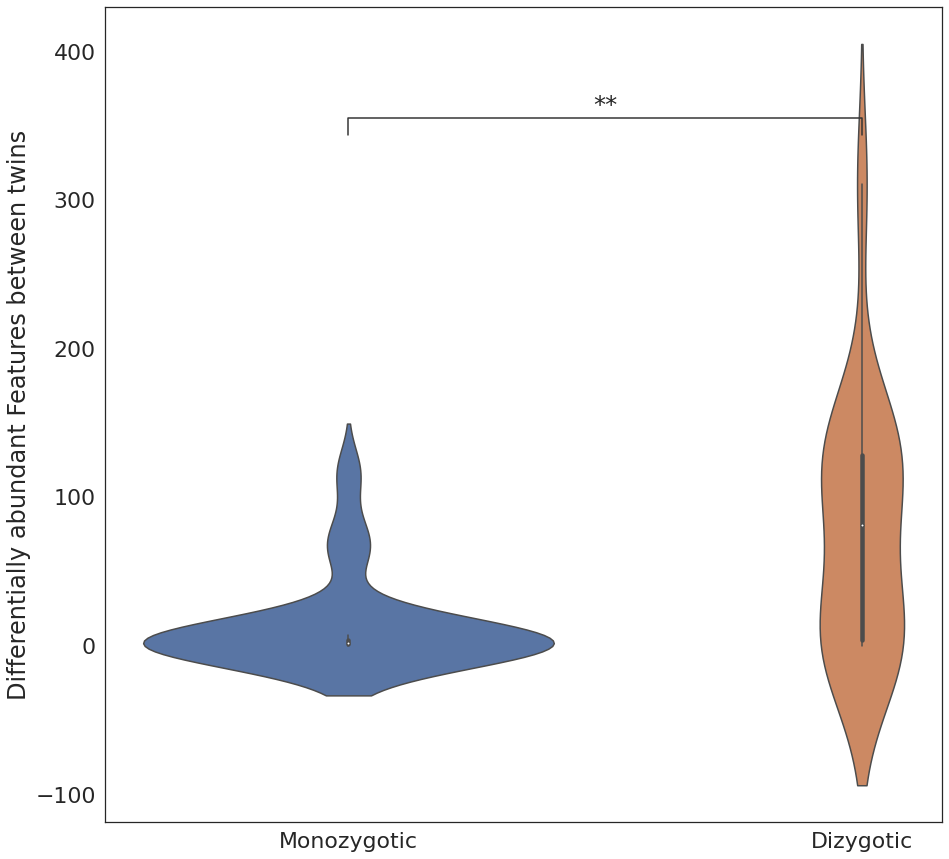

In [31]:
sns.set(rc={'figure.figsize':(15, 15), 'font.family': ['Helvetica']}, style='white')
pairs = [('Monozygotic', 'Dizygotic')]
pvalue = ttest_ind(mono_diff, di_diff)
with sns.plotting_context("notebook", font_scale=2):
    # seaborn's boxplot
    ax = sns.violinplot(
        data=dimono_diff, 
    )
    add_stat_annotation(ax, data=dimono_diff,
                    box_pairs=[('Monozygotic', 'Dizygotic')],
                    test='t-test_ind',
                    text_format='star',
                    loc='inside')
    # matplotlib's customization
    ax.set_ylabel('Differentially abundant Features between twins')
    plt.savefig("Zygosity.jpg")

#### We can do the very same thing comparing the zygosities AND weaning stages:

In [28]:
mono_diff_weaned.columns = ['Monozygotic, weaned']
mono_diff_notweaned.columns = ['Monozygotic, not weaned']
di_diff_weaned.columns = ['Dizygotic, weaned']
di_diff_notweaned.columns = ['Dizygotic, not weaned']

all_diff = pd.concat([mono_diff_weaned, mono_diff_notweaned, di_diff_weaned, di_diff_notweaned], axis=1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Monozygotic, weaned v.s. Monozygotic, not weaned: t-test independent samples with Bonferroni correction, P_val=7.391e-01 stat=-1.575e+00
Monozygotic, not weaned v.s. Dizygotic, weaned: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-4.153e-01
Dizygotic, weaned v.s. Dizygotic, not weaned: t-test independent samples with Bonferroni correction, P_val=5.367e-01 stat=-1.748e+00
Monozygotic, weaned v.s. Dizygotic, weaned: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.106e+00
Monozygotic, not weaned v.s. Dizygotic, not weaned: t-test independent samples with Bonferroni correction, P_val=2.487e-02 stat=-3.056e+00
Monozygotic, weaned v.s. Dizygotic, not weaned: t-test independent samples with Bonferroni correction, P_val=9.299e-04 stat=-4.213e+00


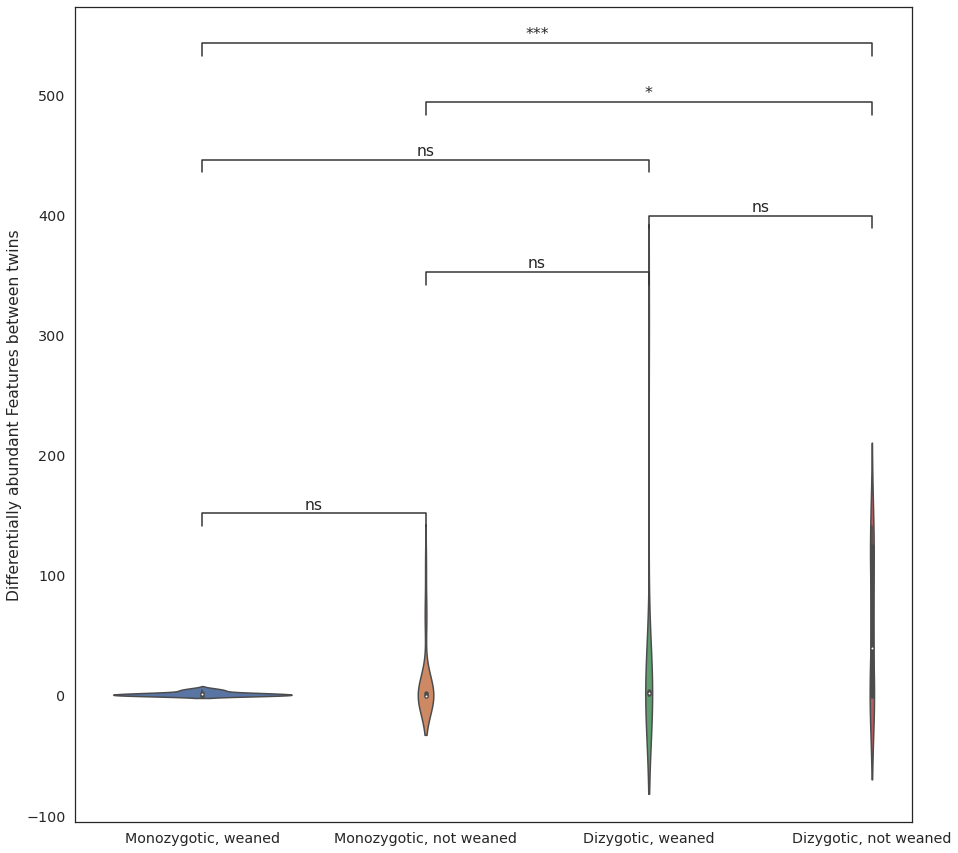

In [29]:
sns.set(rc={'figure.figsize':(15, 15), 'font.family': ['Helvetica']}, style='white')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn's boxplot
    ax = sns.violinplot(
        data=all_diff, 
    )
    add_stat_annotation(ax, data=all_diff,
                    box_pairs=[('Monozygotic, weaned', 'Monozygotic, not weaned'), ('Monozygotic, weaned', 'Dizygotic, weaned'), ('Monozygotic, weaned', 'Dizygotic, not weaned'), ('Monozygotic, not weaned', 'Dizygotic, weaned'), ('Monozygotic, not weaned', 'Dizygotic, not weaned'), ('Dizygotic, weaned', 'Dizygotic, not weaned')],
                    test='t-test_ind',
                    text_format='star',
                    loc='inside')
    # matplotlib's customization
    ax.set_ylabel('Differentially abundant Features between twins')

### 7. Beta diversity for visuals

In [7]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/phylogeny_filtered_table.qza \
    --i-phylogeny $data_dir/reference-tree.qza \
    --p-max-depth 10000 \
    --m-metadata-file $or_dir/new_metadata_for_a_diversity.tsv \
    --o-visualization $data_dir/alpha-rarefaction2.qzv

Saved Visualization to: data/alpha-rarefaction2.qzv


In [8]:
Visualization.load(f'{data_dir}/alpha-rarefaction2.qzv')

<visualization: Visualization uuid: b35ac1ff-5d92-4097-adf1-7cb5a01826d8>

#### Rarefaction at 1500

In [31]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/phylogeny_filtered_table.qza \
  --i-phylogeny $data_dir/reference-tree.qza \
  --m-metadata-file $or_dir/metadata.tsv \
  --p-sampling-depth 1500 \
  --output-dir $data_dir/core-metrics-results

Saved FeatureTable[Frequency] to: data/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: data/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: data/core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: data/core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: data/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: data/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: data/core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: data/core-metrics-results/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: data/core-metrics-results/jaccard_pcoa_results.qza
Sa

In [33]:
Visualization.load(f'{data_dir}/core-metrics-results/unweighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: 56877ca2-4bbb-415b-8c74-b4e8898365a7>

In [34]:
Visualization.load(f'{data_dir}/core-metrics-results/weighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: f3ab4065-f935-417d-8b2a-411956d8d2ff>

### Trying same thing with original metadata (NaN values not turned into weaned):

#### Diet weaning = True:

In [ ]:
for pair in pair_numbers:
    pair1, pair2 = pair + 0.1, pair + 0.2
     
    ! qiime feature-table filter-samples \
        --i-table $data_dir/phylogeny_filtered_table.qza \
        --m-metadata-file $or_dir/metadata.tsv \
        --p-where "[diet_weaning]='True' and ([host_id]=$pair1 or [host_id]=$pair2)" \
        --o-filtered-table $data_dir/pairs/pair_"$pair"_true.qza

Saved FeatureTable[Frequency] to: data/pairs/pair_42.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_27.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_28.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_39.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_8.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_29.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_40.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_35.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_47.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_4.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_3.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_30.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_36.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_6.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_33.0_true.qza
Saved FeatureTable[Frequency] to: data/pairs

#### Diet weaning = False:

In [5]:
for pair in pair_numbers:
    pair1, pair2 = pair + 0.1, pair + 0.2
     
    ! qiime feature-table filter-samples \
        --i-table $data_dir/phylogeny_filtered_table.qza \
        --m-metadata-file $or_dir/metadata.tsv \
        --p-where "[diet_weaning]='False' and ([host_id]=$pair1 or [host_id]=$pair2)" \
        --o-filtered-table $data_dir/pairs/pair_"$pair"_false.qza

Saved FeatureTable[Frequency] to: data/pairs/pair_42.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_27.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_28.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_39.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_8.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_29.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_40.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_35.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_47.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_4.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_3.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_30.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_36.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_6.0_false.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_33.0_false.qza
Saved FeatureTable[Frequency]

#### Diet weaning = NaN:

In [3]:
! qiime feature-table filter-samples --help

Usage: qiime feature-table filter-samples [OPTIONS]

  Filter samples from table based on frequency and/or metadata. Any features
  with a frequency of zero after sample filtering will also be removed. See
  the filtering tutorial on https://docs.qiime2.org for additional details.

Inputs:
  --i-table ARTIFACT FeatureTable[Frequency¹ | RelativeFrequency² |
    PresenceAbsence³ | Composition⁴]
                       The feature table from which samples should be
                       filtered.                                    [required]
Parameters:
  --p-min-frequency INTEGER
                       The minimum total frequency that a sample must have to
                       be retained.                               [default: 0]
  --p-max-frequency INTEGER
                       The maximum total frequency that a sample can have to
                       be retained. If no value is provided this will default
                       to infinity (i.e., no maximum frequency filter will 

In [8]:
metadata['diet_weaning'] = metadata['diet_weaning'].fillna('NaN')
metadata = metadata.set_index('id')
metadata.to_csv(or_dir + '/metadata_nan.tsv', sep = '\t')

In [9]:
for pair in pair_numbers:
    pair1, pair2 = pair + 0.1, pair + 0.2
     
    ! qiime feature-table filter-samples \
        --i-table $data_dir/phylogeny_filtered_table.qza \
        --m-metadata-file $or_dir/metadata_nan.tsv \
        --p-where "[diet_weaning]='NaN' and ([host_id]=$pair1 or [host_id]=$pair2)" \
        --o-filtered-table $data_dir/pairs/pair_"$pair"_nan.qza

Saved FeatureTable[Frequency] to: data/pairs/pair_42.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_27.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_28.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_39.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_8.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_29.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_40.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_35.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_47.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_4.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_3.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_30.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_36.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_6.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_33.0_nan.qza
Saved FeatureTable[Frequency] to: data/pairs/pair_43.0_nan.

#### Pseudocount for all of them:

In [7]:
for pair in pair_numbers:
    ! qiime composition add-pseudocount \
    --i-table $data_dir/pairs/pair_"$pair"_true.qza \
    --o-composition-table $data_dir/pairs/pair_"$pair"_true_pseudo.qza

Saved FeatureTable[Composition] to: data/pairs/pair_42.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_27.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_28.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_39.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_8.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_29.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_40.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_35.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_47.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_4.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_3.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_30.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_36.0_true_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_6.

In [8]:
for pair in pair_numbers:
    ! qiime composition add-pseudocount \
    --i-table $data_dir/pairs/pair_"$pair"_false.qza \
    --o-composition-table $data_dir/pairs/pair_"$pair"_false_pseudo.qza

Saved FeatureTable[Composition] to: data/pairs/pair_42.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_27.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_28.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_39.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_8.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_29.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_40.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_35.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_47.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_4.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_3.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_30.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_36.0_false_pseudo.qza
Saved FeatureTable[Composition] to: data/

In [10]:
for pair in pair_numbers:
    ! qiime composition add-pseudocount \
    --i-table $data_dir/pairs/pair_"$pair"_nan.qza \
    --o-composition-table $data_dir/pairs/pair_"$pair"_nan_pseudo.qza

Saved FeatureTable[Composition] to: data/pairs/pair_42.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_27.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_28.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_39.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_8.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_29.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_40.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_35.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_47.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_4.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_3.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_30.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_36.0_nan_pseudo.qza
Saved FeatureTable[Composition] to: data/pairs/pair_6.0_nan_pseudo.

#### ANCOM for all groups:

In [10]:
! qiime tools cast-metadata $or_dir/metadata.tsv \
--cast host_id:categorical \
--output-file $or_dir/metadata2.tsv

In [11]:
for pair in pair_numbers:
    ! qiime composition ancom \
    --i-table $data_dir/pairs/pair_"$pair"_true_pseudo.qza \
    --m-metadata-file $or_dir/metadata2.tsv \
    --m-metadata-column host_id \
    --p-transform-function log \
    --o-visualization $data_dir/ancoms/ancom_"$pair"_true.qzv

Saved Visualization to: data/ancoms/ancom_42.0_true.qzv
Saved Visualization to: data/ancoms/ancom_27.0_true.qzv
Saved Visualization to: data/ancoms/ancom_28.0_true.qzv
Saved Visualization to: data/ancoms/ancom_39.0_true.qzv
Saved Visualization to: data/ancoms/ancom_8.0_true.qzv
Saved Visualization to: data/ancoms/ancom_29.0_true.qzv
Saved Visualization to: data/ancoms/ancom_40.0_true.qzv
Saved Visualization to: data/ancoms/ancom_35.0_true.qzv
Saved Visualization to: data/ancoms/ancom_47.0_true.qzv
Saved Visualization to: data/ancoms/ancom_4.0_true.qzv
Saved Visualization to: data/ancoms/ancom_3.0_true.qzv
Saved Visualization to: data/ancoms/ancom_30.0_true.qzv
Saved Visualization to: data/ancoms/ancom_36.0_true.qzv
Saved Visualization to: data/ancoms/ancom_6.0_true.qzv
Saved Visualization to: data/ancoms/ancom_33.0_true.qzv
Saved Visualization to: data/ancoms/ancom_43.0_true.qzv
Saved Visualization to: data/ancoms/ancom_44.0_true.qzv
Saved Visualization to: data/ancoms/ancom_45.0_true.

In [12]:
for pair in pair_numbers:
    ! qiime composition ancom \
    --i-table $data_dir/pairs/pair_"$pair"_false_pseudo.qza \
    --m-metadata-file $or_dir/metadata2.tsv \
    --m-metadata-column host_id \
    --p-transform-function log \
    --o-visualization $data_dir/ancoms/ancom_"$pair"_false.qzv

Saved Visualization to: data/ancoms/ancom_42.0_false.qzv
Saved Visualization to: data/ancoms/ancom_27.0_false.qzv
Plugin error from composition:

  All values in `grouping` are unique. This method cannot operate on a grouping vector with only unique values (e.g., there are no 'within' variance because each group of samples contains only a single sample).

Debug info has been saved to /tmp/qiime2-q2cli-err-o4px9t5i.log
Plugin error from composition:

  All values in `grouping` are unique. This method cannot operate on a grouping vector with only unique values (e.g., there are no 'within' variance because each group of samples contains only a single sample).

Debug info has been saved to /tmp/qiime2-q2cli-err-60j_huvg.log
Saved Visualization to: data/ancoms/ancom_8.0_false.qzv
Plugin error from composition:

  `ids_to_keep` must contain at least one ID.

Debug info has been saved to /tmp/qiime2-q2cli-err-fe8ee1jq.log
Saved Visualization to: data/ancoms/ancom_40.0_false.qzv
Plugin error f

In [11]:
for pair in pair_numbers:
    ! qiime composition ancom \
    --i-table $data_dir/pairs/pair_"$pair"_nan_pseudo.qza \
    --m-metadata-file $or_dir/metadata2.tsv \
    --m-metadata-column host_id \
    --p-transform-function log \
    --o-visualization $data_dir/ancoms/ancom_"$pair"_nan.qzv

Saved Visualization to: data/ancoms/ancom_42.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_27.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_28.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_39.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_8.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_29.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_40.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_35.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_47.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_4.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_3.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_30.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_36.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_6.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_33.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_43.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_44.0_nan.qzv
Saved Visualization to: data/ancoms/ancom_45.0_nan.qzv
Saved Visualiz

#### Export:

In [12]:
for pair in pair_numbers:
    !qiime tools export \
      --input-path $data_dir/ancoms/ancom_"$pair"_true.qzv \
      --output-path $data_dir/ancoms/ancom_"$pair"_true.tsv

Exported data/ancoms/ancom_42.0_true.qzv as Visualization to directory data/ancoms/ancom_42.0_true.tsv
Exported data/ancoms/ancom_27.0_true.qzv as Visualization to directory data/ancoms/ancom_27.0_true.tsv
Exported data/ancoms/ancom_28.0_true.qzv as Visualization to directory data/ancoms/ancom_28.0_true.tsv
Exported data/ancoms/ancom_39.0_true.qzv as Visualization to directory data/ancoms/ancom_39.0_true.tsv
Exported data/ancoms/ancom_8.0_true.qzv as Visualization to directory data/ancoms/ancom_8.0_true.tsv
Exported data/ancoms/ancom_29.0_true.qzv as Visualization to directory data/ancoms/ancom_29.0_true.tsv
Exported data/ancoms/ancom_40.0_true.qzv as Visualization to directory data/ancoms/ancom_40.0_true.tsv
Exported data/ancoms/ancom_35.0_true.qzv as Visualization to directory data/ancoms/ancom_35.0_true.tsv
Exported data/ancoms/ancom_47.0_true.qzv as Visualization to directory data/ancoms/ancom_47.0_true.tsv
Exported data/ancoms/ancom_4.0_true.qzv as Visualization to directory data/

In [13]:
for pair in pair_numbers:
    !qiime tools export \
      --input-path $data_dir/ancoms/ancom_"$pair"_false.qzv \
      --output-path $data_dir/ancoms/ancom_"$pair"_false.tsv

Exported data/ancoms/ancom_42.0_false.qzv as Visualization to directory data/ancoms/ancom_42.0_false.tsv
Exported data/ancoms/ancom_27.0_false.qzv as Visualization to directory data/ancoms/ancom_27.0_false.tsv
Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-

In [14]:
for pair in pair_numbers:
    !qiime tools export \
      --input-path $data_dir/ancoms/ancom_"$pair"_nan.qzv \
      --output-path $data_dir/ancoms/ancom_"$pair"_nan.tsv

Exported data/ancoms/ancom_42.0_nan.qzv as Visualization to directory data/ancoms/ancom_42.0_nan.tsv
Exported data/ancoms/ancom_27.0_nan.qzv as Visualization to directory data/ancoms/ancom_27.0_nan.tsv
Exported data/ancoms/ancom_28.0_nan.qzv as Visualization to directory data/ancoms/ancom_28.0_nan.tsv
Exported data/ancoms/ancom_39.0_nan.qzv as Visualization to directory data/ancoms/ancom_39.0_nan.tsv
Exported data/ancoms/ancom_8.0_nan.qzv as Visualization to directory data/ancoms/ancom_8.0_nan.tsv
Exported data/ancoms/ancom_29.0_nan.qzv as Visualization to directory data/ancoms/ancom_29.0_nan.tsv
Exported data/ancoms/ancom_40.0_nan.qzv as Visualization to directory data/ancoms/ancom_40.0_nan.tsv
Exported data/ancoms/ancom_35.0_nan.qzv as Visualization to directory data/ancoms/ancom_35.0_nan.tsv
Exported data/ancoms/ancom_47.0_nan.qzv as Visualization to directory data/ancoms/ancom_47.0_nan.tsv
Exported data/ancoms/ancom_4.0_nan.qzv as Visualization to directory data/ancoms/ancom_4.0_na

#### Count significantly differentially abundant ASVs:

In [15]:
ancoms_true = dict()
for pair in pair_numbers:
    file_exists = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_true.tsv')
    if file_exists == True:
        ancom = pd.read_csv(data_dir + '/ancoms/ancom_'+str(pair)+'_true.tsv/ancom.tsv', sep = '\t')
        ancoms_true[pair] = ancom[ancom['Reject null hypothesis']==True]

In [16]:
ancoms_false = dict()
for pair in pair_numbers:
    file_exists = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_false.tsv')
    if file_exists == True:
        ancom = pd.read_csv(data_dir + '/ancoms/ancom_'+str(pair)+'_false.tsv/ancom.tsv', sep = '\t')
        ancoms_false[pair] = ancom[ancom['Reject null hypothesis']==True]

In [17]:
ancoms_nan = dict()
for pair in pair_numbers:
    file_exists = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_nan.tsv')
    if file_exists == True:
        ancom = pd.read_csv(data_dir + '/ancoms/ancom_'+str(pair)+'_nan.tsv/ancom.tsv', sep = '\t')
        ancoms_nan[pair] = ancom[ancom['Reject null hypothesis']==True]

In [46]:
all_pairs = dict()
for pair in pair_numbers:
    pair1 = pair+0.1
    pair2 = pair+0.2
    twin1 = metadata[metadata['host_id']==pair1]
    twin2 = metadata[metadata['host_id']==pair1]
    all_pairs = twin1.merge(twin2, axis=0)

TypeError: merge() got an unexpected keyword argument 'axis'

In [21]:
mono_nrs = dict()
for pair in monozygotic_ids:
    existence_true = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_true.tsv')
    existence_false = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_false.tsv')
    existence_nan = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_nan.tsv')
    if existence_true == True:
        number_true = len(ancoms_true[pair].index)
    if existence_false == True:
        number_false = len(ancoms_false[pair].index)
    if existence_nan == True:
        number_nan = len(ancoms_nan[pair].index)
    number = number_true + number_false + number_nan
    mono_nrs[pair] = number

In [22]:
di_nrs = dict()
for pair in dizygotic_ids:
    existence_true = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_true.tsv')
    existence_false = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_false.tsv')
    existence_nan = exists(f'{data_dir}/ancoms/ancom_'+str(pair)+'_nan.tsv')
    if existence_true == True:
        number_true = len(ancoms_true[pair].index)
    if existence_false == True:
        number_false = len(ancoms_false[pair].index)
    if existence_nan == True:
        number_nan = len(ancoms_nan[pair].index)
    number = number_true + number_false + number_nan
    di_nrs[pair] = number

In [33]:
monos_diff = pd.DataFrame.from_dict(mono_nrs, orient='index')
dis_diff = pd.DataFrame.from_dict(di_nrs, orient='index')
monos_diff

,0
42.0,4
28.0,3
39.0,3
40.0,3
35.0,6
47.0,581
3.0,2
30.0,9
36.0,61
43.0,4


In [30]:
monos_diff.mean()

0    65.666667
dtype: float64

In [31]:
dis_diff.mean()

0    48.388889
dtype: float64

In [24]:
monos_diff.columns = ['Monozygotic']
dis_diff.columns = ['Dizygotic']
dimonos_diff = pd.concat([monos_diff, dis_diff], axis=1)
dimonos_diff

,Monozygotic,Dizygotic
2.0,NaN,5.0
3.0,2.0,NaN
4.0,NaN,3.0
5.0,NaN,2.0
8.0,NaN,6.0
10.0,NaN,143.0
11.0,NaN,4.0
12.0,119.0,NaN
13.0,4.0,NaN
14.0,NaN,141.0


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Monozygotic v.s. Dizygotic: t-test independent samples with Bonferroni correction, P_val=6.810e-01 stat=4.144e-01


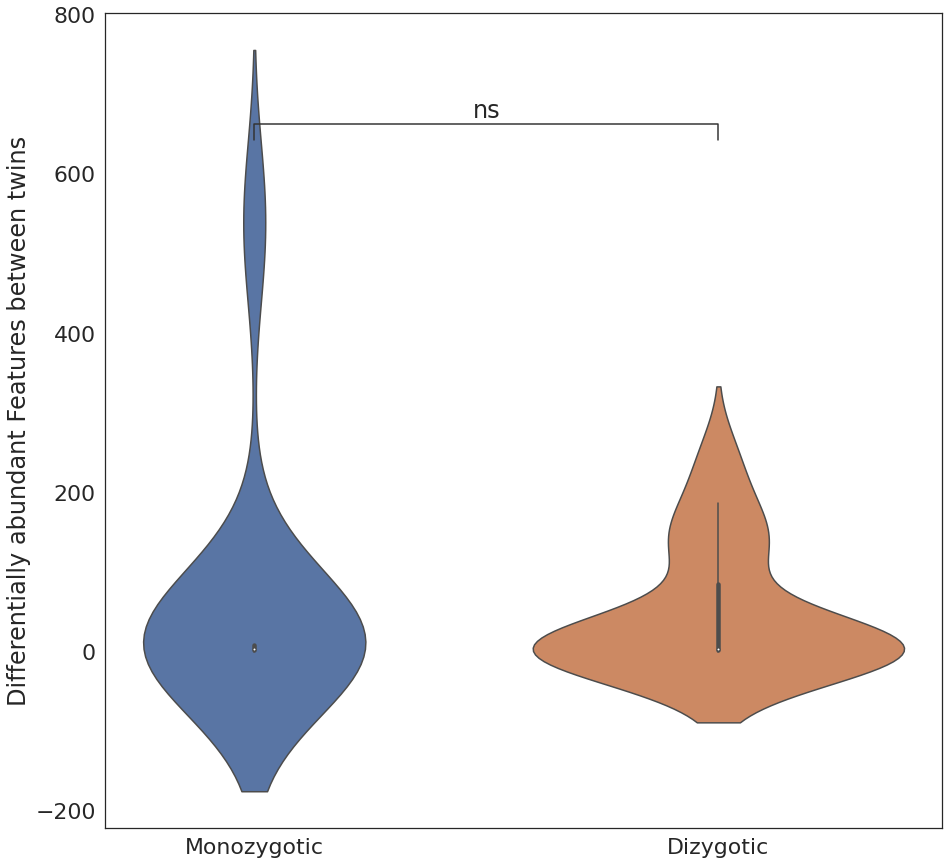

In [25]:
sns.set(rc={'figure.figsize':(15, 15), 'font.family': ['Helvetica']}, style='white')
pairs = [('Monozygotic', 'Dizygotic')]
pvalue = ttest_ind(monos_diff, dis_diff)
with sns.plotting_context("notebook", font_scale=2):
    # seaborn's boxplot
    ax = sns.violinplot(
        data=dimonos_diff, 
    )
    add_stat_annotation(ax, data=dimonos_diff,
                    box_pairs=[('Monozygotic', 'Dizygotic')],
                    test='t-test_ind',
                    text_format='star',
                    loc='inside')
    # matplotlib's customization
    ax.set_ylabel('Differentially abundant Features between twins')